# 数据集

# 数据集地址
## Flickr-8k(1GB): 
https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download
### 图片描述json(50MB): 
https://cs.stanford.edu/people/karpathy/deepimagesent/flickr8k.zip
## Flicker-30k(9GB): 
https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset?resource=download
### 图片描述json (200MB): 
https://cs.stanford.edu/people/karpathy/deepimagesent/flickr30k.zip

### 下载好后请把数据放在项目文件夹中的flickr8k文件夹 和 flickr30k文件夹中，图片放在所属数据集下/images文件夹中


大概如下：
```markdown
项目文件夹
|
├── flicker8k
|   |
|   ├── Images
|   |       └── 1GB的图片
|   ├── dataset.json
|   ├── vgg_feats.mat
|   └── readme.txt
|
├── flicker30k
|   |
|   ├── Images
|   |       └── 9GB的图片
|   ├── dataset.json
|   ├── vgg_feats.mat
|   └── readme.txt
|
└── data_prep_flickr.ipynb
    
```



# 数据集创建

In [1]:
import json
import os 
import random
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
def create_dataset(dataset='flickr8k', captions_per_image=5, min_word_count=5, max_len=30):
    """
    创建图像描述数据集。该函数会读取指定的数据集，根据给定的参数处理文本描述，并生成相应的词汇表和数据集文件。

    参数：
        dataset (str): 数据集名称，默认为'flickr8k'。
        captions_per_image (int): 每张图片对应的文本描述数，默认为5。
        min_word_count (int): 仅考虑在数据集中（除测试集外）至少出现指定次数的词，默认为5次。
        max_len (int): 文本描述包含的最大单词数。如果文本描述超过该值，则进行截断，默认为30。

    输出：
        vocab.json: 包含数据集中所有有效词汇的词典文件。
        train_data.json: 训练集文件，包含训练集中的图片路径和对应的编码后文本描述。
        val_data.json: 验证集文件，包含验证集中的图片路径和对应的编码后文本描述。
        test_data.json: 测试集文件，包含测试集中的图片路径和对应的编码后文本描述。
    """
    
    karpathy_json_path = f"/kaggle/input/{dataset}-source/dataset.json"  # 设置Karpathy的JSON文件路径，该文件包含数据集的图片信息和文本描述。
    image_folder = f"/kaggle/input/{dataset}/Images/"  # 设置图片文件夹的路径。
    output_folder = "/kaggle/working/data/%s" % dataset  # 设置输出文件夹的路径，用于存放处理后的数据集文件和词汇表文件。

    # 确保输出文件夹存在，如果不存在则创建。
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 读取数据集文本描述的JSON文件。
    with open(file=karpathy_json_path, mode="r") as j:
        data = json.load(fp=j)
    
    # 初始化字典和计数器用于存储图片路径、图片文本描述以及词频统计。
    image_paths = defaultdict(list)  # 用于存储每个数据集分割（train/val/test）的图片路径。
    image_captions = defaultdict(list)  # 用于存储每个数据集分割的图片对应的文本描述。
    vocab = Counter()  # 用于统计数据集中词汇的出现频率。

    # 遍历数据集中的每张图片和其文本描述。
    for img in data["images"]:
        split = img["split"]  # 获取图片所属的数据集分割（train/val/test）。
        captions = []  # 用于临时存储符合条件的文本描述。
        
        # 遍历图片的所有文本描述。
        for c in img["sentences"]:
            # 对于非测试集的数据，更新词频统计。
            if split != "test":
                vocab.update(c['tokens'])
            
            # 如果文本描述的长度小于等于最大长度限制，则添加到临时列表中。
            if len(c["tokens"]) <= max_len:
                captions.append(c["tokens"])
        
        # 如果没有符合条件的文本描述，则跳过当前图片。
        if len(captions) == 0:
            continue
        
        # 构建图片路径并存储。
        path = os.path.join(image_folder, img['filename'])
        image_paths[split].append(path)
        image_captions[split].append(captions)
    
    # 创建词典并添加特殊标记，如<pad>、<unk>、<start>、<end>。
    words = [w for w in vocab.keys() if vocab[w] > min_word_count]  # 过滤低频词。
    vocab = {k: v + 1 for v, k in enumerate(words)}  # 创建词汇表并为每个词分配唯一索引。
    
    # 添加特殊标记到词汇表。
    vocab['<pad>'] = 0
    vocab['<unk>'] = len(vocab)
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)
    
    # 将词汇表保存到文件。
    with open(os.path.join(output_folder, 'vocab.json'), "w") as fw:
        json.dump(vocab, fw)
    
    # 对每个数据集分割（train/val/test）的图片路径和文本描述进行处理并保存。
    for split in image_paths:
        imgpaths = image_paths[split]
        imcaps = image_captions[split]
        enc_captions = []  # 用于存储编码后的文本描述。
        
        # 遍历当前分割下的所有图片路径。
        for i, path in enumerate(imgpaths):
            # 打开图片以检查其是否可以被解析。
            img = Image.open(path)
            
            # 如果图像对应的描述数量不足，则随机选择描述进行补足。
            if len(imcaps[i]) < captions_per_image:
                filled_num = captions_per_image - len(imcaps[i])
                captions = imcaps[i] + [random.choice(imcaps[i]) for _ in range(filled_num)]
            else:
                captions = random.sample(imcaps[i], k=captions_per_image)
            
            assert len(captions) == captions_per_image  # 确保每张图片有足够的描述。
            
            # 对每个文本描述进行编码。
            for j, c in enumerate(captions):
                enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']]
                enc_captions.append(enc_c)
        
        assert len(imgpaths) * captions_per_image == len(enc_captions)  # 确保编码后的描述数量正确。
        
        # 构建数据集并保存到文件。
        data = {"IMAGES": imgpaths, "CAPTIONS": enc_captions}
        with open(os.path.join(output_folder, split + "_data.json"), 'w') as fw:
            json.dump(data, fw)


In [3]:
create_dataset(dataset='flickr8k', min_word_count=5, max_len=30)
# create_dataset(dataset='flickr30k', min_word_count=5, max_len=30)

# 创建后

In [2]:
import json
import os 
import random
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# 选择你要使用的数据集

In [3]:
dataset = "flickr8k" # "flickr30k

2
1000
5000
<start>agroupofmenwearingyellow<unk>walkinaline<end>
<start>menwalkinlinecarryingthings<end>
<start>peopleinorangerobeslineupbehindamanwearingsunglasses<end>
<start>three<unk>walkonthestreet<end>
<start>threemeninorangerobesholdingmetal<unk><end>


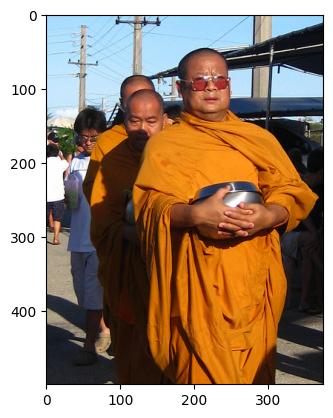

In [4]:
# 加载词汇表文件
with open(f'/kaggle/working/data/{dataset}/vocab.json','r') as f:
    vocab = json.load(f)

# 将词汇表从词到索引的映射转换为索引到词的映射
vocab_idx2word = {idx: word for word, idx in vocab.items()}
 
# 加载测试数据集文件
with open(f'/kaggle/working/data/{dataset}/test_data.json','r') as f:
    data = json.load(f)

# 从测试数据集中选择一张图片（第301张图片，因为索引从0开始）并显示
content_img = Image.open(data['IMAGES'][300])
plt.imshow(content_img)
# 打印数据集的基本信息
print(len(data))  # 打印data字典中键的数量，通常应该是2（'IMAGES' 和 'CAPTIONS'）
print(len(data['IMAGES']))  # 打印测试集中图片的总数
print(len(data["CAPTIONS"]))  # 打印测试集中文本描述的总数
 
# 对于选定的图片，打印其所有（5个）对应的文本描述
for i in range(5):
    # 计算当前图片对应的第i个描述的索引（每张图片有5个描述）
    word_indeces = data['CAPTIONS'][300*5+i]
    # 将文本描述的索引列表转换为单词列表，并连接成字符串打印出来
    print(''.join([vocab_idx2word[idx] for idx in word_indeces]))

In [5]:
class ImageTextDataset(Dataset):
    """
    PyTorch 数据集类，用于从指定的数据集中加载图像和对应的文本描述。
    可以配合 PyTorch DataLoader 使用，以便在模型训练或评估时按批次产生数据。
    """
    def __init__(self, dataset_path, vocab_path, split, captions_per_image=5, max_len=30, transform=None):
        """
        初始化 ImageTextDataset 实例。

        参数：
            dataset_path (str): JSON 格式数据文件的路径，该文件包含图像路径和对应的文本描述。
            vocab_path (str): JSON 格式字典文件的路径，该文件包含数据集中单词到索引的映射。
            split (str): 数据集的哪一部分将被加载，可选值为 "train", "val", "test"。
            captions_per_image (int): 每张图片对应的文本描述数量，默认为5。
            max_len (int): 文本描述中允许的最大单词数量，默认为30。
            transform (callable, optional): 一个函数或变换，用于对每张图像进行预处理。如果为None，则不应用任何预处理。

        注意：
            - 数据文件和词典文件应该是JSON格式，并且具有特定的结构。
            - 数据文件应包含两个键："IMAGES" 和 "CAPTIONS"，分别对应图像路径列表和文本描述列表。
            - 词典文件应包含单词到索引的映射。
        """
        self.split = split
        assert self.split in {"train", "val", "test"}, "split 参数必须是 'train', 'val', 或 'test' 其中之一。"
        self.cpi = captions_per_image
        self.max_len = max_len
 
        # 加载图像和文本描述数据
        with open(dataset_path, "r") as f:
            self.data = json.load(f)
        
        # 加载词典
        with open(vocab_path, "r") as f:
            self.vocab = json.load(f)
        
        # 设置图像预处理流程
        self.transform = transform
 
        # 计算数据集大小（即文本描述的总数量）
        self.dataset_size = len(self.data["CAPTIONS"])
    
    def __getitem__(self, i):
        """
        获取第 i 个数据点。

        参数：
            i (int): 数据点的索引。

        返回：
            tuple: 包含三个元素的元组 (img, caption, caplen)。
                - img (Tensor): 经过预处理的图像。
                - caption (Tensor): 对应的文本描述，已转换为单词索引的序列，并进行了适当的填充。
                - caplen (int): 原始文本描述的长度（不包括填充）。
        """
        # 计算对应的图像索引，并加载图像
        img = Image.open(self.data['IMAGES'][i // self.cpi]).convert("RGB")
        
        # 如果设置了图像预处理，则应用之
        if self.transform is not None:
            img = self.transform(img)
        
        # 获取文本描述的实际长度，并根据最大长度进行填充
        caplen = len(self.data["CAPTIONS"][i])
        pad_caps = [self.vocab['<pad>']] * (self.max_len + 2 - caplen)  # 注意填充以达到 max_len + 2
        caption = torch.LongTensor(self.data["CAPTIONS"][i] + pad_caps)
 
        return img, caption, caplen
 
    def __len__(self):
        """
        获取数据集中数据点的总数。

        返回：
            int: 数据集中数据点的总数。
        """
        return self.dataset_size


In [6]:
def make_train_val(data_dir, vocab_path, batch_size, workers=0):
    """
    创建并返回训练集、验证集和测试集的数据加载器。

    参数:
        data_dir (str): 包含数据集文件的目录路径。
        vocab_path (str): JSON 格式字典文件的路径，该文件包含数据集中单词到索引的映射。
        batch_size (int): 数据加载器每批次加载的数据点数量。
        workers (int): 用于数据加载的子进程数量，默认为0。

    返回:
        tuple: 包含三个元素的元组 (train_loader, val_loader, test_loader)，
               分别对应训练集、验证集和测试集的数据加载器。
    """
    # 定义训练集的图像预处理流程
    train_tx = transforms.Compose([
        transforms.Resize(256),  # 将图像缩放到256x256像素
        transforms.RandomCrop(224),  # 从图像中随机裁剪一个224x224像素的区域
        transforms.ToTensor(),  # 将图像数据转换为PyTorch张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 对图像数据进行标准化处理
    ])
 
    # 定义验证集和测试集的图像预处理流程
    val_tx = transforms.Compose([
        transforms.Resize(256),  # 将图像缩放到256x256像素
        transforms.CenterCrop(224),  # 从图像中心裁剪一个224x224像素的区域
        transforms.ToTensor(),  # 将图像数据转换为PyTorch张量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 对图像数据进行标准化处理
    ])
 
    # 创建训练集、验证集和测试集的数据集实例
    train_set = ImageTextDataset(dataset_path=os.path.join(data_dir, "train_data.json"), vocab_path=vocab_path, split="train", transform=train_tx)
    vaild_set = ImageTextDataset(dataset_path=os.path.join(data_dir, "val_data.json"), vocab_path=vocab_path, split="val", transform=val_tx)
    test_set = ImageTextDataset(dataset_path=os.path.join(data_dir, "test_data.json"), vocab_path=vocab_path, split="test", transform=val_tx)
 
    # 创建训练集的数据加载器
    train_loader = DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True
    )
 
    # 创建验证集的数据加载器
    val_loader = DataLoader(
        dataset=vaild_set, batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True, drop_last=False
    )
 
    # 创建测试集的数据加载器
    test_loader = DataLoader(
        dataset=test_set, batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True, drop_last=False
    )
 
    return train_loader, val_loader, test_loader


# 模型

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from tqdm import tqdm

# CNN+LSTM

In [ ]:
class EncoderCNN(nn.Module):
    """
    EncoderCNN 使用预训练的 ResNet50 模型作为基础，用于提取图像特征。
    """
    def __init__(self, embed_size):
        """
        初始化 EncoderCNN。

        参数:
            embed_size (int): 图像特征嵌入的维度。
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # 加载预训练的 ResNet50 模型
        # resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
             param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]  # 移除最后的全连接层，获取卷积层
        self.resnet = nn.Sequential(*modules)  # 将卷积层作为特征提取器
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)  # 添加一个全连接层，用于将特征映射到嵌入空间
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)  # 添加批量归一化层
        
    def forward(self, images):
        """
        前向传播。

        参数:
            images (Tensor): 输入的图像张量。

        返回:
            Tensor: 图像的嵌入特征。
        """
        with torch.no_grad():  # 不计算梯度，以加快速度
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)  # 将特征展平
        features = self.bn(self.linear(features))  # 通过全连接层和批量归一化层
    
    #def forward(self, images):
    #    features = self.resnet(images)                                    #(batch_size,2048,7,7)
    #    features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
    #    features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
    #    return features
        
        return features

In [ ]:
class DecoderRNN(nn.Module):
    """
    DecoderRNN 使用 LSTM 网络对图像的特征进行解码，生成图像的描述。
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout=0.1):
        """
        初始化 DecoderRNN。

        参数:
            embed_size (int): 嵌入向量的维度。
            hidden_size (int): LSTM 隐藏层的维度。
            vocab_size (int): 词汇表的大小。
            num_layers (int): LSTM 层的数量。
        """
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)  # 嵌入层，将单词索引映射为嵌入向量
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)  # LSTM 网络
        self.linear = nn.Linear(hidden_size, vocab_size)  # 全连接层，将 LSTM 的输出映射到词汇表上
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features, captions):
        """
        前向传播。

        参数:
            features (Tensor): 图像的嵌入特征。
            captions (Tensor): 描述的单词索引。

        返回:
            Tensor: 预测的单词索引。
        """
        embeddings = self.embed(captions)  # 将单词索引映射为嵌入向量
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)  # 将图像特征与文本嵌入向量拼接
        hiddens, _ = self.lstm(embeddings)  # 通过 LSTM 网络
        hiddens = self.dropout(hiddens)
        outputs = self.linear(hiddens)  # 映射到词汇表
        return outputs

In [ ]:
class EncoderDecoder(nn.Module):
    """
    EncoderDecoder 将 EncoderCNN 和 DecoderRNN 结合起来，形成一个完整的图像描述生成模型。
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        """
        初始化 EncoderDecoder。

        参数:
            embed_size (int): 嵌入向量的维度。
            hidden_size (int): LSTM 隐藏层的维度。
            vocab_size (int): 词汇表的大小。
            num_layers (int): LSTM 层的数量。
        """
        super(EncoderDecoder, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)  # 图像特征编码器
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)  # 文本描述解码器
        
    def forward(self, images, captions):
        """
        前向传播。

        参数:
            images (Tensor): 输入的图像张量。
            captions (Tensor): 描述的单词索引。

        返回:
            Tensor: 预测的单词索引。
        """
        features = self.encoderCNN(images)  # 提取图像特征
        outputs = self.decoderRNN(features, captions)  # 生成描述
        return outputs
    
    def caption_image(self, image, vocabulary, max_length=50):
        """
        为给定的图像生成描述。

        参数:
            image (Tensor): 输入的图像张量。
            vocabulary (dict): 索引到单词的映射字典。
            max_length (int): 生成描述的最大长度。

        返回:
            list: 包含描述中单词的列表。
        """
        result_caption = []  # 存储生成的描述

        with torch.no_grad():  # 不计算梯度
            x = self.encoderCNN(image).unsqueeze(0)  # 提取图像特征
            states = None  # 初始化 LSTM 状态
            
            for _ in range(max_length):  # 生成描述
                hiddens, states = self.decoderRNN.lstm(x, states)  # 通过 LSTM
                output = self.decoderRNN.linear(hiddens.squeeze(1))  # 映射到词汇表
                print(output.shape)
                predicted = output.argmax(1)  # 选择概率最高的单词
                print(predicted)
                result_caption.append(predicted.item())  # 添加到结果中
                x = self.decoderRNN.embed(predicted).unsqueeze(0)  # 准备下一轮的输入

                if vocabulary[predicted.item()] == "<end>":  # 如果生成了结束标记，则停止
                    break

        return [vocabulary[idx] for idx in result_caption]  # 将索引转换为单词


# Transformer model

## Base Transformer with CNN

In [106]:
class EncoderCNN(nn.Module):
    """
    EncoderCNN 使用预训练的 ResNet50 模型作为基础，用于提取图像特征。
    """
    def __init__(self, embed_size):
        """
        初始化 EncoderCNN。

        参数:
            embed_size (int): 图像特征嵌入的维度。
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # 加载预训练的 ResNet50 模型
        # resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
             param.requires_grad_(False)
        
        # modules = list(resnet.children())[:-1]  # 移除最后的全连接层，获取卷积层
        modules = list(resnet.children())[:-2]  # 移除最后的全连接层，获取卷积层
        self.resnet = nn.Sequential(*modules)  # 将卷积层作为特征提取器
        # self.linear = nn.Linear(resnet.fc.in_features, embed_size)  # 添加一个全连接层，用于将特征映射到嵌入空间
        self.linear = nn.Linear(2048, embed_size)  # 添加一个全连接层，用于将特征映射到嵌入空间
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)  # 添加批量归一化层
        # self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, images):
        """
        前向传播。

        参数:
            images (Tensor): 输入的图像张量。

        返回:
            Tensor: 图像的嵌入特征。
        """
        with torch.no_grad():  # 不计算梯度，以加快速度
            features = self.resnet(images)
        
        # features = features.reshape(features.size(0), -1)  # 将特征展平
        #features = F.relu(self.bn(self.linear(features)))  # 通过全连接层和批量归一化层
        
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        features = F.relu(self.linear(features)) #(batch_size,49,embed_size)
        
        return features

In [107]:
# 定义位置编码
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [108]:
# 定义Transformer结构
class Transformer(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, d_model=512, nhead=8, num_encoder_layers=4, num_decoder_layers=4):
        super(Transformer, self).__init__()
        self.model_type = 'transformer'
        self.src_mask = None
        self.embed = nn.Embedding(vocab_size, d_model)  # 嵌入层，将单词索引映射为嵌入向量
        self.pos_encoder = PositionalEncoding(d_model, dropout=0.1)
        self.vocab_size = vocab_size
        
        # 编码器和解码器的参数
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)
        self.feature_linear = nn.Linear(embed_size, d_model)
        self.linear1 = nn.Linear(d_model, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, captions):
        # features是编码器的输入，captions是解码器的输入
        # features = self.feature_linear(features)
        # features = features.unsqueeze(1)
        captions = self.embed(captions)
        captions = self.pos_encoder(captions)
        
        # 生成Mask确保在解码器中只能使用当前时间步之前的单词
        captions_mask = nn.Transformer.generate_square_subsequent_mask(captions.size(1)).to(device)
        
        # 编码器的输出
        enc_output = self.transformer_encoder(features)
        
        # 解码器的输出
        dec_output = self.transformer_decoder(captions, enc_output, tgt_mask=captions_mask)
        
        # 线性层
        output = self.linear1(dec_output)
        output = F.relu(output)
        output = self.linear2(output)
        
        return output

In [109]:
class EncoderDecoder(nn.Module):
    """
    EncoderDecoder 将 EncoderCNN 和 DecoderTransformer 结合起来，形成一个完整的图像描述生成模型。
    """
    def __init__(self, embed_size, hidden_size, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers):
        """
        初始化 EncoderDecoder。

        参数:
            embed_size (int): 嵌入向量的维度。
            hidden_size (int): 隐藏层的维度。
            vocab_size (int): 词汇表的大小。
            nhead (int): 头的个数。
            num_encoder_layers
            num_decoder_layers
        """
        super(EncoderDecoder, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)  # 图像特征编码器
        self.decoderTransformer = Transformer(embed_size, hidden_size, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers)  # 文本描述解码器
            
    def forward(self, images, captions):
        """
        前向传播。

        参数:
            images (Tensor): 输入的图像张量。
            captions (Tensor): 描述的单词索引。

        返回:
            Tensor: 预测的单词索引。
        """
        features = self.encoderCNN(images)  # 提取图像特征
        outputs = self.decoderTransformer(features, captions)  # 生成描述
        return outputs
    
    def caption_image(self, image, vocabulary, max_length=30):
        """
        为给定的图像生成描述。

        参数:
            image (Tensor): 输入的图像张量。
            vocabulary (dict): 索引到单词的映射字典。
            max_length (int): 生成描述的最大长度。

        返回:
            list: 包含描述中单词的列表。
        """
        result_caption = []  # 存储生成的描述

        with torch.no_grad():  # 不计算梯度
            x = self.encoderCNN(image)  # 提取图像特征
            enc_output = self.decoderTransformer.transformer_encoder(x)#.unsqueeze(1)
            # print(x.shape)
            caps = torch.zeros(1, max_length+1).long().to(device)  # 初始化描述的张量
            caps[:, 0] = vocab['<start>']  # 第一个单词是起始标记
            
            for i in range(max_length):  # 生成描述
                output = self.decoderTransformer.embed(caps[:, :i+1])  # 获取当前时间步之前的所有单词的嵌入
                output = self.decoderTransformer.pos_encoder(output)  # 添加位置编码
                output = self.decoderTransformer.transformer_decoder(output, enc_output)  # 解码
                output = self.decoderTransformer.linear1(output)  # 线性层1
                output = F.relu(output)  # ReLU激活函数
                output = self.decoderTransformer.linear2(output)  # 线性层2
                predicted = output[:, -1, :].argmax(1)  # 获取当前时间步的预测单词
                result_caption.append(predicted.item())  # 添加到结果中
                caps[:, i+1] = predicted.item()  # 将预测单词添加到描述中
                
                if vocabulary[predicted.item()] == "<end>":  # 如果生成了结束标记，则停止
                    break
            
        return [vocabulary[idx] for idx in result_caption]  # 将索引转换为单词

## SCA-Transformer with CNN

In [77]:
# 定义位置编码
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [78]:
class MultiheadSelfAttention(nn.Module):
    """
    多头自注意力机制。
    """
    def __init__(self, d_model, nhead):
        """
        初始化多头自注意力机制。

        参数:
            d_model (int): 模型的维度。
            nhead (int): 头的数量。
        """
        super(MultiheadSelfAttention, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.dim_per_head = d_model // nhead
        
        assert self.dim_per_head * nhead == d_model, "d_model必须被nhead整除"
        
        self.query_projection = nn.Linear(d_model, d_model)
        self.key_projection = nn.Linear(d_model, d_model)
        self.value_projection = nn.Linear(d_model, d_model)
        self.output_projection = nn.Linear(d_model, d_model)
        self.batch_first = True
        
    def forward(self, query, key, value, mask=None):
        """
        前向传播。

        参数:
            query (Tensor): 查询张量。
            key (Tensor): 键张量。
            value (Tensor): 值张量。
            mask (Tensor): 可选的遮罩张量。

        返回:
            Tensor: 自注意力机制的输出张量。
        """
        batch_size = query.size(0)
        
        IN = nn.InstanceNorm1d(query.size(1))
        
        # 将输入进行线性变换并分成多个头
        query = IN(self.query_projection(query)).view(batch_size, -1, self.nhead, self.dim_per_head).transpose(1, 2) # (batch_size, nhead, seq_len, dim_per_head)
        key = self.key_projection(key).view(batch_size, -1, self.nhead, self.dim_per_head).transpose(1, 2) # (batch_size, nhead, seq_len, dim_per_head)
        value = self.value_projection(value).view(batch_size, -1, self.nhead, self.dim_per_head).transpose(1, 2) # (batch_size, nhead, seq_len, dim_per_head)
        
        # 计算注意力分数
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / (self.dim_per_head ** 0.5)
        
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))
        
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_weights, value)
        
        # 将多个头的输出连接起来
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        # 进行线性变换
        attention_output = self.output_projection(attention_output)
        
        return attention_output

In [79]:
class EncoderCNN(nn.Module):
    """
    EncoderCNN 使用预训练的 ResNet50 模型作为基础，用于提取图像特征。
    """
    def __init__(self, embed_size):
        """
        初始化 EncoderCNN。

        参数:
            embed_size (int): 图像特征嵌入的维度。
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # 加载预训练的 ResNet50 模型
        # resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
             param.requires_grad_(False)
        
        # modules = list(resnet.children())[:-1]  # 移除最后的全连接层，获取卷积层
        modules = list(resnet.children())[:-2]  # 移除最后的全连接层，获取卷积层
        self.resnet = nn.Sequential(*modules)  # 将卷积层作为特征提取器
        # self.linear = nn.Linear(resnet.fc.in_features, embed_size)  # 添加一个全连接层，用于将特征映射到嵌入空间
        self.linear = nn.Linear(2048, embed_size)  # 添加一个全连接层，用于将特征映射到嵌入空间
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)  # 添加批量归一化层
        # self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, images):
        """
        前向传播。

        参数:
            images (Tensor): 输入的图像张量。

        返回:
            Tensor: 图像的嵌入特征。
        """
        with torch.no_grad():  # 不计算梯度，以加快速度
            features = self.resnet(images)
        
        # features = features.reshape(features.size(0), -1)  # 将特征展平
        #features = F.relu(self.bn(self.linear(features)))  # 通过全连接层和批量归一化层
        
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        features = F.relu(self.linear(features)) #(batch_size,49,embed_size)
        
        return features

In [80]:
class EncoderLayer(nn.Module):
    """
    编码器的单层。
    """
    def __init__(self, d_model, nhead):
        """
        初始化编码器的单层。

        参数:
            d_model (int): 模型的维度。
            nhead (int): 头的数量。
        """
        super(EncoderLayer, self).__init__()
        self.linear1 = nn.Linear(d_model, 2048)  # 第一个线性层
        self.linear2 = nn.Linear(2048, d_model)  # 第二个线性层
        self.norm1 = nn.LayerNorm(d_model)  # 自标准化归一化层
        self.norm2 = nn.LayerNorm(d_model)  # 自标准化归一化层
        self.dropout = nn.Dropout(0.1)  # Dropout层
        
    def forward(self, src, src_mask=None):
        """
        前向传播。

        参数:
            src (Tensor): 输入张量。(batch_size,n,d_model)
            src_mask (Tensor): 可选的遮罩张量。

        返回:
            Tensor: 输出张量。
        """ 
        # src = src.to(device) #(batch_size,49,embed_size)
        feature_size = src.size(1)
        channel_size = src.size(2)
        self.s_attn = MultiheadSelfAttention(channel_size, nhead).to(device)  # 新的自注意力模块
        self.c_attn = MultiheadSelfAttention(feature_size, 7).to(device)  # 新的自注意力模块
            
        src2 = self.s_attn(src, src, src, mask=src_mask)  # 自注意力 #(batch_size,f,c)
        src2 = src2.view(src2.size(0),channel_size,feature_size) #(batch_size,c,f)
        src2 = self.c_attn(src2, src2, src2, mask=src_mask)  # 自注意力 #(batch_size,c,f)
        src2 = src2.view(src2.size(0),feature_size,channel_size) #(batch_size,f,c)
        src = src + self.dropout(src2)  # 添加残差连接和Dropout
        src = self.norm1(src)  # 自标准化归一化
        
        src2 = self.linear2(F.relu(self.linear1(src)))  # 线性变换
        src = src + self.dropout(src2)  # 添加残差连接和Dropout
        src = self.norm2(src)  # 自标准化归一化
        return src

In [81]:
# 定义Transformer结构
class Transformer(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, d_model=512, nhead=8, num_encoder_layers=4, num_decoder_layers=4):
        super(Transformer, self).__init__()
        self.model_type = 'transformer'
        self.src_mask = None
        self.embed = nn.Embedding(vocab_size, d_model)  # 嵌入层，将单词索引映射为嵌入向量
        self.pos_encoder = PositionalEncoding(d_model, dropout=0.1)
        self.vocab_size = vocab_size
        
        # 编码器和解码器的参数
        encoder_layer = EncoderLayer(d_model, nhead)  # 自定义的编码器层
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        self.transformer_encoder = nn.ModuleList(
            [encoder_layer for _ in range(num_encoder_layers)]
        )

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, batch_first=True)
        # decoder_layer = DecoderLayer(d_model, nhead)  # 自定义的解码器层
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)
        
        self.feature_linear = nn.Linear(embed_size, d_model)
        self.linear1 = nn.Linear(d_model, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, captions):
        # features是编码器的输入，captions是解码器的输入
        # features = self.feature_linear(features) 
        # features = features.unsqueeze(1) ## (batch_size,channel_size,d_model)
        captions = self.embed(captions)
        captions = self.pos_encoder(captions)
        
        # 生成Mask确保在解码器中只能使用当前时间步之前的单词
        captions_mask = nn.Transformer.generate_square_subsequent_mask(captions.size(1)).to(device)
        
        # 编码器的输出
        #enc_output = self.transformer_encoder(features)
        enc_output = features
        for layer in self.transformer_encoder:
            enc_output = layer(enc_output)
            
        # 解码器的输出
        dec_output = self.transformer_decoder(captions, enc_output, tgt_mask=captions_mask)
        
        # 线性层
        output = self.linear1(dec_output)
        output = F.relu(output)
        output = self.linear2(output)
        
        return output

In [82]:
# 复制一个Encoder-Decoder类
class EncoderDecoder(nn.Module):
    """
    EncoderDecoder 将 EncoderCNN 和 DecoderTransformer 结合起来，形成一个完整的图像描述生成模型。
    """
    def __init__(self, embed_size, hidden_size, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers):
        """
        初始化 EncoderDecoder。

        参数:
            embed_size (int): 嵌入向量的维度。
            hidden_size (int): 隐藏层的维度。
            vocab_size (int): 词汇表的大小。
            nhead (int): 头的个数。
            num_encoder_layers
            num_decoder_layers
        """
        super(EncoderDecoder, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)  # 图像特征编码器
        self.decoderTransformer = Transformer(embed_size, hidden_size, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers)  # 文本描述解码器
            
    def forward(self, images, captions):
        """
        前向传播。

        参数:
            images (Tensor): 输入的图像张量。
            captions (Tensor): 描述的单词索引。

        返回:
            Tensor: 预测的单词索引。
        """
        features = self.encoderCNN(images)  # 提取图像特征
        outputs = self.decoderTransformer(features, captions)  # 生成描述
        return outputs
    
    def caption_image(self, image, vocabulary, max_length=30):
        """
        为给定的图像生成描述。

        参数:
            image (Tensor): 输入的图像张量。
            vocabulary (dict): 索引到单词的映射字典。
            max_length (int): 生成描述的最大长度。

        返回:
            list: 包含描述中单词的列表。
        """
        result_caption = []  # 存储生成的描述

        with torch.no_grad():  # 不计算梯度
            image = image.to(device)
            x = self.encoderCNN(image)  # 提取图像特征
            # 注意：可能需要对features进行处理以匹配解码器的输入要求
            enc_output = x#.unsqueeze(1)
            
            for layer in self.decoderTransformer.transformer_encoder:
                enc_output = layer(enc_output)

            caps = torch.zeros(1, max_length+1).long().to(device)  # 初始化描述的张量
            caps[:, 0] = vocab['<start>']  # 第一个单词是起始标记
            
            for i in range(max_length):  # 生成描述
                output = self.decoderTransformer.embed(caps[:, :i+1])  # 获取当前时间步之前的所有单词的嵌入
                output = self.decoderTransformer.pos_encoder(output)  # 添加位置编码
                output = self.decoderTransformer.transformer_decoder(output, enc_output)  # 解码
                output = self.decoderTransformer.linear1(output)  # 线性层1
                output = F.relu(output)  # ReLU激活函数
                output = self.decoderTransformer.linear2(output)  # 线性层2
                predicted = output[:, -1, :].argmax(1)  # 获取当前时间步的预测单词
                result_caption.append(predicted.item())  # 添加到结果中
                caps[:, i+1] = predicted.item()  # 将预测单词添加到描述中
                
                if vocabulary[predicted.item()] == "<end>":  # 如果生成了结束标记，则停止
                    break
            
        return [vocabulary[idx] for idx in result_caption]  # 将索引转换为单词

# train and valid and test

In [16]:
def train(model, train_loader, val_loader, optimizer, lr_schedule, criterion, num_epochs, device):
    """
    训练给定的模型。

    参数:
        model: 要训练的模型。
        data_loader: 数据加载器，用于按批次提供训练数据。
        optimizer: 优化器，用于更新模型的权重。
        criterion: 损失函数，用于计算预测和真实标签之间的差异。
        num_epochs: 训练的总轮数。
        device: 指定训练使用的设备，例如 'cuda' 或 'cpu'。
    """
    # 训练循环中的学习率调整  
    val_record_interval = 1 # 验证频率
    train_loss_list = []
    val_loss_list = []
    cur_loss = float('inf')
    
    for epoch in range(num_epochs):  # 遍历每一个训练轮次
        if lr_schedule:
            adjust_learning_rate(optimizer, epoch+1)  # 调整学习率
            # lr_schedule.step()  # 更新学习率
            
        model.train()  # 将模型设置为训练模式
        train_loop = tqdm(train_loader, leave=True)  # 使用tqdm封装data_loader以显示进度条
        train_loss = 0
        for images, captions, lengths in train_loop:  # 遍历数据加载器中的每个批次
            images = images.to(device)  # 将图像数据移动到指定的设备上
            captions = captions.to(device)  # 将文本描述数据也移动到指定的设备上
            outputs = model(images, captions[:, :-1])  # 执行前向传播，注意这里captions去掉了最后一个词，因为它用作预测的起点
            # print(outputs.shape)
            outputs = outputs[:, :captions.size(1)-1, :].contiguous()  # 调整输出以匹配损失函数的期望输入形状
            outputs_reshaped = outputs.contiguous().view(-1, outputs.size(2))  # 重新调整输出的形状以适应损失函数
            targets = captions[:, 1:].contiguous().view(-1)  # 准备目标标签，移除了每个序列的第一个词
            # print(outputs.shape, outputs_reshaped.shape, targets.shape)
            
            loss = criterion(outputs_reshaped, targets)  # 计算损失
            train_loss += loss
            
            optimizer.zero_grad()  # 清空之前的梯度
            loss.backward()  # 反向传播，计算当前梯度
            optimizer.step()  # 根据梯度更新模型的参数
            
            # 更新进度条信息
            train_loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')  # 显示当前轮次
            train_loop.set_postfix(loss=loss.item())  # 显示当前损失值
            
        train_average_loss = float(train_loss/len(train_loader))
        print('Train average loss:',train_average_loss)
        train_loss_list.append(train_average_loss)
        
        if epoch % val_record_interval == 0:
            model.eval()
            with torch.no_grad():
                val_loop = tqdm(val_loader, leave=True)  # 使用tqdm封装data_loader以显示进度条
                val_loss = 0
                for images, captions, lengths in val_loop:  # 遍历数据加载器中的每个批次
                    images = images.to(device)  # 将图像数据移动到指定的设备上
                    captions = captions.to(device)  # 将文本描述数据也移动到指定的设备上
                    outputs = model(images, captions[:, :-1])  # 执行前向传播，注意这里captions去掉了最后一个词，因为它用作预测的起点
                    outputs = outputs[:, :captions.size(1)-1, :].contiguous()  # 调整输出以匹配损失函数的期望输入形状
                    outputs_reshaped = outputs.contiguous().view(-1, outputs.size(2))  # 重新调整输出的形状以适应损失函数
                    targets = captions[:, 1:].contiguous().view(-1)  # 准备目标标签，移除了每个序列的第一个词
                    
                    loss = criterion(outputs_reshaped, targets)  # 计算损失
                    val_loss += loss
                    
                    # 更新进度条信息
                    val_loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')  # 显示当前轮次
                    val_loop.set_postfix(loss=loss.item())  # 显示当前损失值
                    
            val_average_loss = float(val_loss/len(val_loader))
            if val_average_loss < cur_loss:
                cur_loss = val_average_loss
                best_model = model
                
            print('Val average loss:',val_average_loss)
            val_loss_list.append(val_average_loss)
        
    return train_loss_list,val_loss_list,best_model

In [ ]:
# Baseline
# 设定超参数
embed_size = 512  # 图像特征的嵌入维度
hidden_size = 512  # LSTM隐藏层的大小
vocab_size = len(vocab)  # 词汇表的大小
num_layers = 1  # LSTM的层数

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)

# 初始化模型
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers)
# 移动模型到配置的设备（GPU/CPU）
model = model.to(device)

In [110]:
# CNN and Transformer
# 设定超参数
embed_size = 512  # 图像特征的嵌入维度 与d_model相同，不同时需要加入一个Linear层
hidden_size = 2048  # FFN隐藏层的大小
vocab_size = len(vocab)  # 词汇表的大小
d_model = 512
nhead = 8
num_encoder_layers = 4
num_decoder_layers = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)

# 初始化模型
model = EncoderDecoder(embed_size, hidden_size, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers)
# 移动模型到配置的设备（GPU/CPU）
model = model.to(device)

Using:  cuda


In [ ]:
import os
os.environ["CUDA VISIBLE DEVICES"]='0,1'
model = nn.DataParallel(model)
model = model.to(device)

In [ ]:
total_num = sum(p.numel() for p in model.parameters())
trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_num,trainable_num

In [111]:
batch_size = 30
train_loader, val_loader, test_loader = make_train_val(
    f"/kaggle/working/data/{dataset}",f"/kaggle/working/data/{dataset}/vocab.json", batch_size)

# 定义损失函数
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])  # 忽略<pad>标记的损失计算

Using:  cuda
torch.Size([30, 3, 224, 224]) torch.Size([30, 32])
['<start>', 'the', 'spotted', 'dog', 'rolls', 'on', 'its', 'back', '<end>']
['<start>', 'a', 'spotted', 'dog', 'rolling', 'over', 'on', 'a', 'pad', 'placed', 'on', 'a', 'porch', '<end>']
['<start>', 'a', 'dog', 'lays', 'on', 'a', '<unk>', 'on', 'the', 'porch', '<end>']
['<start>', 'a', 'dog', 'rolls', 'on', 'a', '<unk>', 'placed', 'on', 'a', 'porch', 'and', '<unk>', 'his', 'back', '<end>']
['<start>', 'a', 'white', 'dog', 'rolling', 'on', 'its', 'back', 'on', 'a', 'porch', '<end>']


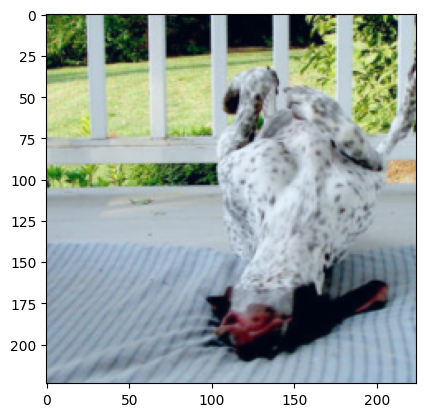

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)

i = 0
for images, captions, lengths in test_loader:  # 遍历数据加载器中的每个批次
    i = i + 1
    if i < 3:
        continue
    images = images.to(device)  # 将图像数据移动到指定的设备上
    captions = captions.to(device)  # 将文本描述数据也移动到指定的设备上
    print(images.shape,captions.shape)
    # 准备图像数据用于显示
    image = images[0].cpu().permute(1, 2, 0).numpy()  # 将图像数据移动到CPU并调整维度以便用matplotlib显示
    # 如果图像数据是浮点数，确保它们在 [0, 1] 范围内
    if image.dtype == np.float32 or image.dtype == np.float64:
        if image.min() < 0 or image.max() > 1:
            image = (image - image.min()) / (image.max() - image.min())  # 归一化到 [0, 1]
    # 如果图像数据是整数，确保它们在 [0, 255] 范围内
    elif image.dtype == np.uint8:
        image = np.clip(image, 0, 255)
    # plt.imshow(image)
    image0 = image
    image = images[1].cpu().permute(1, 2, 0).numpy()  # 将图像数据移动到CPU并调整维度以便用matplotlib显示
    # 如果图像数据是浮点数，确保它们在 [0, 1] 范围内
    if image.dtype == np.float32 or image.dtype == np.float64:
        if image.min() < 0 or image.max() > 1:
            image = (image - image.min()) / (image.max() - image.min())  # 归一化到 [0, 1]
    # 如果图像数据是整数，确保它们在 [0, 255] 范围内
    elif image.dtype == np.uint8:
        image = np.clip(image, 0, 255)
    plt.imshow(image0)
    print([vocab_idx2word[idx.item()] for idx in captions[0] if idx.item()!=0])
    print([vocab_idx2word[idx.item()] for idx in captions[1] if idx.item()!=0])
    print([vocab_idx2word[idx.item()] for idx in captions[2] if idx.item()!=0])
    print([vocab_idx2word[idx.item()] for idx in captions[3] if idx.item()!=0])
    print([vocab_idx2word[idx.item()] for idx in captions[4] if idx.item()!=0])
    break

In [69]:
learning_rate = 3e-4

# 初始化优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
from torch.optim.lr_scheduler import LambdaLR,StepLR,ExponentialLR

# 定义优化器，使用Adam优化器
optimizer = torch.optim.Adam(model.parameters())

# 定义学习率调整策略
def adjust_learning_rate(optimizer, epoch):
    """
    调整学习率。

    参数:
        optimizer (Optimizer): 优化器。
        epoch (int): 当前的epoch数。
    """
    if epoch<=6:
        base_lr = min(epoch * 1e-4, 3e-4)  # 计算基础学习率
        for param_group in optimizer.param_groups:
            param_group['lr'] = base_lr
            
    # 如果当前epoch数大于6并且可以整除3，则将学习率衰减为原来的一半
    elif epoch > 6 and (epoch - 6) % 3 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5

# 定义学习率衰减策略
lr_schedule = StepLR(optimizer, step_size=3, gamma=0.5)

#lr_schedule = LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1))

#lr_schedule = ExponentialLR(optimizer, gamma=0.5)

# train and valid

In [23]:
# 清理不需要的torch内存
torch.cuda.empty_cache()

In [20]:
num_epochs = 2  # 训练的轮数
train_loss_list,val_loss_list,best_model = train(model, train_loader, val_loader, optimizer, True, criterion, num_epochs, device)

Epoch [1/2]: 100%|██████████| 1000/1000 [46:17<00:00,  2.78s/it, loss=3.32]


Train average loss: 3.6380045413970947


Epoch [1/2]: 100%|██████████| 167/167 [05:08<00:00,  1.85s/it, loss=3.39]


Val average loss: 3.107999801635742


Epoch [2/2]: 100%|██████████| 1000/1000 [31:03<00:00,  1.86s/it, loss=2.8]


Train average loss: 2.8781816959381104


Epoch [2/2]: 100%|██████████| 167/167 [03:34<00:00,  1.29s/it, loss=3.01]


Val average loss: 2.858288526535034


In [21]:
train_loss_list,val_loss_list

([3.6380045413970947, 2.8781816959381104],
 [3.107999801635742, 2.858288526535034])

## 读取断点状态继续训练

In [27]:
# CNN and Transformer
# 设定超参数
embed_size = 512  # 图像特征的嵌入维度 与d_model相同，不同时需要加入一个Linear层
hidden_size = 2048  # FFN隐藏层的大小
vocab_size = len(vocab)  # 词汇表的大小
d_model = 512
nhead = 8
num_encoder_layers = 4
num_decoder_layers = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)

# 初始化模型
model = EncoderDecoder(embed_size, hidden_size, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers)
# 移动模型到配置的设备（GPU/CPU）
model = model.to(device)

# 读取断点信息
start_epoch = -1
path_checkpoint = "/kaggle/working/model/SCA_Transformer_2_checkpoint(full).pth"  # 断点路径
checkpoint = torch.load(path_checkpoint)  # 加载断点
#model.load_state_dict(checkpoint['model'])  # 加载模型可学习参数
model = torch.load('/kaggle/working/model/SCA_Transformer_2_best(full).pth') # 读取整个模型
optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
start_epoch = checkpoint['epoch']  # 设置开始的epoch
lr_schedule.load_state_dict(checkpoint['lr_schedule'])#加载lr_scheduler

Using:  cpu


In [28]:
num_epochs = 2  # 继续训练的轮数
train_loss_list,val_loss_list,best_model = train(model, train_loader, val_loader, optimizer, True, criterion, num_epochs, device)

Epoch [3/2]: 100%|██████████| 1000/1000 [45:10<00:00,  2.71s/it, loss=2.8]


Train average loss: 2.55076265335083


Epoch [3/2]: 100%|██████████| 167/167 [05:06<00:00,  1.83s/it, loss=3.01]


Val average loss: 2.8593339920043945


Epoch [4/2]: 100%|██████████| 1000/1000 [30:38<00:00,  1.84s/it, loss=2.74]


Train average loss: 2.549776077270508


Epoch [4/2]: 100%|██████████| 167/167 [03:29<00:00,  1.26s/it, loss=3.01]


Val average loss: 2.8589115142822266


In [29]:
train_loss_list,val_loss_list

([2.55076265335083, 2.549776077270508],
 [2.8593339920043945, 2.8589115142822266])

# test

## DataParallel

In [34]:
# CNN
# base Transformer
# 设定超参数
embed_size = 128  # 图像特征的嵌入维度 与d_model相同，不同时需要加入一个Linear层
hidden_size = 512  # FFN隐藏层的大小
vocab_size = len(vocab)  # 词汇表的大小
d_model = 128
nhead = 8
num_encoder_layers = 2
num_decoder_layers = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)

# 初始化模型
test_model = EncoderDecoder(embed_size, hidden_size, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers)

Using:  cuda


In [35]:
model_path = "/kaggle/working/best_model_state_dict.pth"

# 保存模型参数
torch.save(best_model.module.state_dict(), model_path)
# torch.save(best_model, model_path)

### DataParallel化
test_model = nn.DataParallel(test_model)
### 一定要先.module
test_model = test_model.module

### 使用state_dicts实例化
test_model.load_state_dict(torch.load(model_path))
# test_model = torch.load(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model.to(device)

EncoderDecoder(
  (encoderCNN): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

In [121]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)
# 读取整个模型
test_model = torch.load('/kaggle/input/transofmer-model/CNN_BaseTransformer_10_best.pth')
#test_model = torch.load('/kaggle/input/transofmer-model/SCA_Transformer_10_best(2 layer).pth')
#test_model = torch.load('/kaggle/input/transofmer-model/SCA_Transformer_10_best(4 layer).pth')

Using:  cuda


Generated caption: two dogs are running in the snow


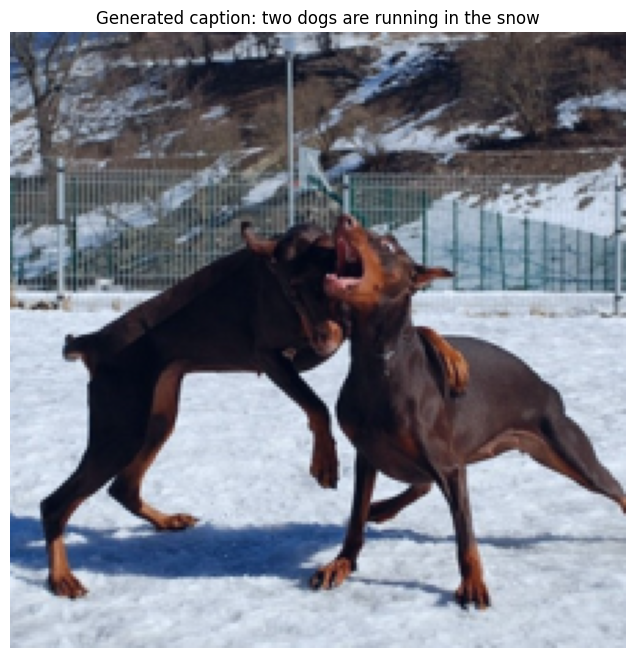

Generated caption: a girl in a crowd of <unk> hat


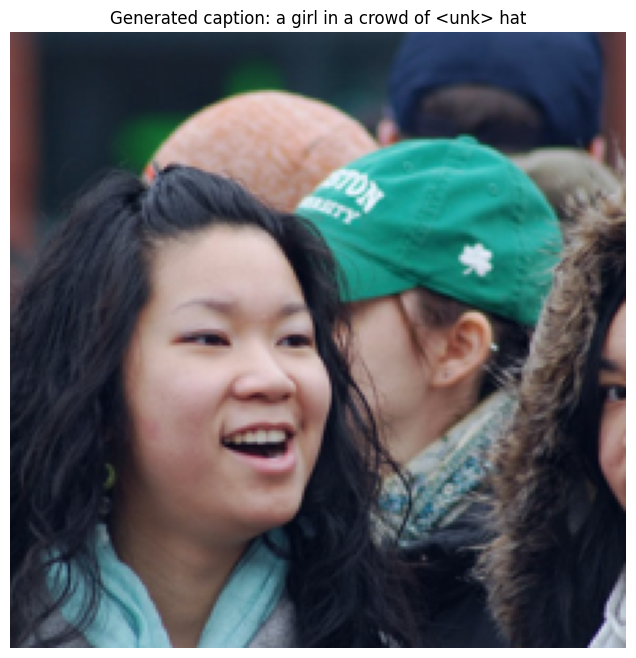

Generated caption: a dog looking up at a tree


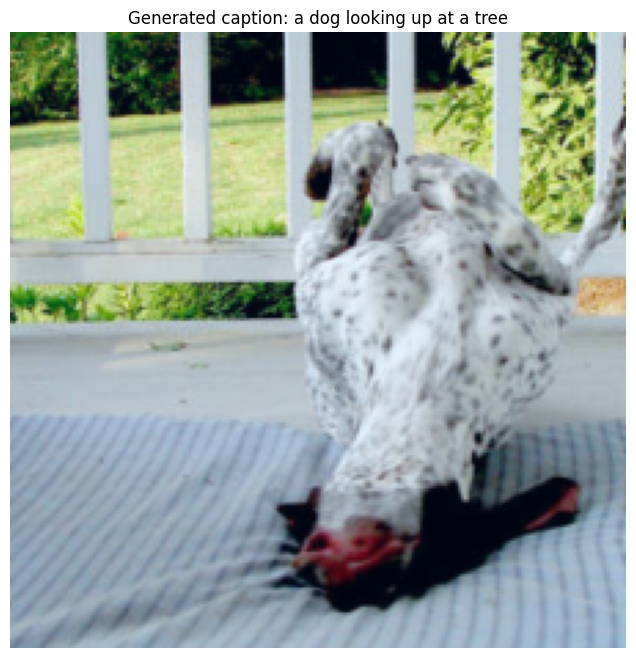

In [113]:
import matplotlib.pyplot as plt
import numpy as np  # 确保导入numpy库

def generate_and_display_captions(model, data_loader, vocab, device):
    """
    为数据加载器中的图像生成描述并显示。

    参数:
        model: 训练好的图像描述模型。
        data_loader: 数据加载器，包含要生成描述的图像。
        vocab: 词汇表，一个从索引到单词的映射。
        device: 设备类型，例如 'cuda' 或 'cpu'。
    """
    model.eval()  # 将模型设置为评估模式
    i = 0
    for images, _, _ in data_loader:  # 迭代数据加载器中的每个批次
        image = images[0].to(device).unsqueeze(0)  # 仅处理每个批次的第一张图像，并将其移动到指定设备
        caption = model.caption_image(image, vocab)  # 使用模型为图像生成描述
        generated_caption = ' '.join(caption[:-1])  # 将生成的描述列表连接成字符串
        print(f"Generated caption: {generated_caption}")  # 打印生成的描述
        
        # 准备图像数据用于显示
        image = image.squeeze().cpu().permute(1, 2, 0).numpy()  # 将图像数据移动到CPU并调整维度以便用matplotlib显示
        
        # 如果图像数据是浮点数，确保它们在 [0, 1] 范围内
        if image.dtype == np.float32 or image.dtype == np.float64:
            if image.min() < 0 or image.max() > 1:
                image = (image - image.min()) / (image.max() - image.min())  # 归一化到 [0, 1]
    
        # 如果图像数据是整数，确保它们在 [0, 255] 范围内
        elif image.dtype == np.uint8:
            image = np.clip(image, 0, 255)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Generated caption: {generated_caption}")
        plt.axis('off')  # 不显示坐标轴
        plt.show()  # 显示图像和描述
        i += 1
        if i == 3:  # 仅显示前三张图像及其描述
            break

# 假设vocab是一个从索引到单词的映射
vocab_idx2word = {idx: word for word, idx in vocab.items()}

# 使用测试集DataLoader
captions = generate_and_display_captions(test_model, test_loader, vocab_idx2word, device)

# Metrics:
### BLEU-1/2/3/4
### METEOR
### ROUGE-L
### CIDEr
### SPICE 

In [17]:
#!pip install nltk==3.5
!pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [18]:
!pip install rouge_metric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 1.6 MB/s eta 0:00:00a 0:00:01m


In [19]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 20.6 MB/s eta 0:00:00


In [20]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_metric import PyRouge
from pycocoevalcap.cider.cider import Cider

smooth = SmoothingFunction()

# Calculates BLEU score of predictions
def BLEU_score(gts, caps):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    # gts eg:   [[["this", "is", "an", "apple"]]]
    # caps eg:  [["an", "apple", "on", "this", "tree"]]
    corpus_score_1 = sentence_bleu(gts, caps, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
    corpus_score_2 = sentence_bleu(gts, caps, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
    corpus_score_3 = sentence_bleu(gts, caps, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
    corpus_score_4 = sentence_bleu(gts, caps, smoothing_function=smooth.method1)
    return [
        round(corpus_score_1, 5), round(corpus_score_2, 5), round(corpus_score_3, 5), round(corpus_score_4, 5)
    ]

def METEOR_score(gts, caps):
    # gts eg:   [["this", "is", "an", "apple"]]
    # caps eg:  ["an", "apple", "on", "this", "tree"]
    return meteor_score(gts, caps)

def rouge_score(gts, caps):
    # gts eg:   [[["this", "is", "an", "apple"]]]
    # caps eg:  [["an", "apple", "on", "this", "tree"]]
    rouge = PyRouge(rouge_n=(1, 2), rouge_l=True, rouge_w=False, rouge_s=False, rouge_su=False)
    score = rouge.evaluate_tokenized(caps, gts)
    return score

def Cider_score(gts, caps):
    cider_scorer = Cider()
    score,_ = cider_scorer.compute_score(ref_sentences, pred_sentence)
    return score

In [122]:
def evaluate_model(model, data_loader, vocab):
    bleu = {1:[], 2:[], 3:[], 4:[]}
    meteor = []
    rouge = {1:{'r':[],'p':[],'f':[]}, 2:{'r':[],'p':[],'f':[]}, 'l':{'r':[],'p':[],'f':[]}}
    
    model.eval()  # 将模型设置为评估模式
    ref_sentences = dict()
    pred_sentence = dict()
    index = 0
    
    for idx, (images, ground_truths, _) in enumerate(iter(data_loader)):
        for i in range(0,images.shape[0],5):
            ground_truth_list = []
            ground_truth_str = []
            for j in range(5):
                ground_truth=[vocab_idx2word[idx.item()] for idx in ground_truths[i+j] if idx.item()!=0]
                ground_truth_list.append(ground_truth[1:-1])
                ground_truth_str.append(' '.join(ground_truth[1:-1]))
                
            image = images[i].to(device).unsqueeze(0)  # 仅处理每个批次的第一张图像，并将其移动到指定设备
            caption = model.caption_image(image, vocab)  # 使用模型为图像生成描述
            caption = caption[:-1] #去掉end符
            
            ref_sentences[index] = ground_truth_str
            pred_sentence[index] = [' '.join(caption)]
            index += 1
        
            score = BLEU_score(ground_truth_list, caption)
            bleu[1].append(score[0])
            bleu[2].append(score[1])
            bleu[3].append(score[2])
            bleu[4].append(score[3])
            
            score = METEOR_score(ground_truth_list, caption)
            meteor.append(score)
            
            score = rouge_score([ground_truth_list], [caption])
            rouge[1]['r'].append(score['rouge-1']['r'])
            rouge[1]['p'].append(score['rouge-1']['p'])
            rouge[1]['f'].append(score['rouge-1']['f'])
            
            rouge[2]['r'].append(score['rouge-2']['r'])
            rouge[2]['p'].append(score['rouge-2']['p'])
            rouge[2]['f'].append(score['rouge-2']['f'])
            
            rouge['l']['r'].append(score['rouge-l']['r'])
            rouge['l']['p'].append(score['rouge-l']['p'])
            rouge['l']['f'].append(score['rouge-l']['f'])
            
    return bleu, meteor, rouge, Cider_score(ref_sentences, pred_sentence), ref_sentences, pred_sentence

In [123]:
# average score
bleu, meteor, rouge, cider, ref_sentences, pred_sentence = evaluate_model(test_model, test_loader, vocab_idx2word)

In [124]:
bleu_1_mean = np.mean(np.array(bleu[1]))
bleu_2_mean = np.mean(np.array(bleu[2]))
bleu_3_mean = np.mean(np.array(bleu[3]))
bleu_4_mean = np.mean(np.array(bleu[4]))
bleu_1_mean,bleu_2_mean,bleu_3_mean,bleu_4_mean

(0.561678, 0.38238509, 0.24821659000000001, 0.1654401)

In [116]:
meteor_mean = np.mean(np.array(meteor))
meteor_mean

0.37755008258280054

In [117]:
rouge_1_r_mean = np.mean(np.array(rouge[1]['r']))
rouge_1_p_mean = np.mean(np.array(rouge[1]['p']))
rouge_1_f_mean = np.mean(np.array(rouge[1]['f']))
rouge_1_r_mean,rouge_1_p_mean,rouge_1_f_mean

(0.546184736797155, 0.7375122997763924, 0.603556245202306)

In [118]:
rouge_2_r_mean = np.mean(np.array(rouge[2]['r']))
rouge_2_p_mean = np.mean(np.array(rouge[2]['p']))
rouge_2_f_mean = np.mean(np.array(rouge[2]['f']))
rouge_2_r_mean,rouge_2_p_mean,rouge_2_f_mean

(0.27129241300591866, 0.3767948298324474, 0.30320364063120375)

In [119]:
rouge_l_r_mean = np.mean(np.array(rouge['l']['r']))
rouge_l_p_mean = np.mean(np.array(rouge['l']['p']))
rouge_l_f_mean = np.mean(np.array(rouge['l']['f']))
rouge_l_r_mean,rouge_l_p_mean,rouge_l_f_mean

(0.5356916448280146, 0.7241724026020976, 0.592289777326097)

In [125]:
cider

0.45678922560266283

## 1. CNN_BaseTransformer_10_best

### param
batch_size = 30
embed_size = 512
hidden_size = 2048
vocab_size = len(vocab)

d_model = 512
nhead = 8
num_encoder_layers = 4
num_decoder_layers = 4

### result
bleu_1_mean,bleu_2_mean,bleu_3_mean,bleu_4_mean

(0.561678, 0.38238509, 0.24821659000000001, 0.1654401)

meteor_mean 

0.37755008258280054

rouge_1_r_mean,rouge_1_p_mean,rouge_1_f_mean

(0.5462227399717331, 0.7374645421052674, 0.6035785403707246)

rouge_2_r_mean,rouge_2_p_mean,rouge_2_f_mean

(0.2712862817040815, 0.3767508792151634, 0.30319380856433287)

rouge_l_r_mean,rouge_l_p_mean,rouge_l_f_mean

(0.5357208350364339, 0.724111741705166, 0.5923014239216248)

cider

0.45678922560266283

## 2. SCA_Transformer_10_best(2 layer)

### param
batch_size = 10
embed_size = 128
hidden_size = 512
vocab_size = len(vocab)

d_model = 128
nhead = 8
num_encoder_layers = 2
num_decoder_layers = 2

### result
bleu_1_mean,bleu_2_mean,bleu_3_mean,bleu_4_mean

(0.59588467, 0.41214680000000004, 0.27046906000000004, 0.17856300000000003)

meteor_mean 

0.4066115536467445

rouge_1_r_mean,rouge_1_p_mean,rouge_1_f_mean

(0.5896281132330421, 0.7275762797193742, 0.6332124592141499)

rouge_2_r_mean,rouge_2_p_mean,rouge_2_f_mean

(0.29464880333533766, 0.37327506929605836, 0.319710242054756)

rouge_l_r_mean,rouge_l_p_mean,rouge_l_f_mean

(0.5770516147193626, 0.7144534317443063, 0.6205201022693887)

cider

0.4638132227223372

## 3. SCA_Transformer_10_best(4 layer)
### param
batch_size = 10
embed_size = 128
hidden_size = 512
vocab_size = len(vocab)

d_model = 128
nhead = 8
num_encoder_layers = 4
num_decoder_layers = 4

### result
bleu_1_mean,bleu_2_mean,bleu_3_mean,bleu_4_mean

(0.5817072300000001, 0.40281957, 0.26377712000000003, 0.17642465999999998)

meteor_mean 

0.38090548736060087

rouge_1_r_mean,rouge_1_p_mean,rouge_1_f_mean

(0.5339895554974287, 0.7518527421248847, 0.6028611884376198)

rouge_2_r_mean,rouge_2_p_mean,rouge_2_f_mean

(0.29593860104881753, 0.3741600558418553, 0.3209116664301116)

rouge_l_r_mean,rouge_l_p_mean,rouge_l_f_mean

(0.5782861714215779, 0.7149045963819649, 0.6215729875856022)

cider

0.5138141430494839

# model save

In [24]:
# 确保输出文件夹存在，如果不存在则创建。
if not os.path.exists('/kaggle/working/model'):
    os.makedirs('/kaggle/working/model')

In [40]:
# 保存整个模型
torch.save(best_model, '/kaggle/working/model/SCA_Transformer_4_best(full).pth')

In [41]:
# 保存模型的状态字典
torch.save(best_model.state_dict(), '/kaggle/working/model/SCA_Transformer_4_best_state_dict(full).pth')

In [42]:
# 断点保存
checkpoint = {
        "model": model.state_dict(),
        'optimizer':optimizer.state_dict(),
        'lr_schedule': lr_schedule.state_dict(),
        "epoch": num_epochs
    }

# 保存断点的状态字典
torch.save(checkpoint, '/kaggle/working/model/SCA_Transformer_4_checkpoint(full).pth')

# model read

In [ ]:
# 设置超参数和定义class
# 读取整个模型
model = torch.load('/kaggle/working/model/nic_10.pth')

In [ ]:
# 设定一些超参数
embed_size = 512  # 图像特征的嵌入维度
hidden_size = 512  # LSTM隐藏层的大小
vocab_size = len(vocab)  # 词汇表的大小
num_layers = 1  # LSTM的层数

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)

# 初始化模型
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers)
# 移动模型到配置的设备（GPU/CPU）
model = model.to(device)

# 读取模型的状态字典
loaded_state_dict = torch.load('/kaggle/working/model/nic_10_state_dict.pth')

# 将读取的状态字典加载到模型中
model.load_state_dict(loaded_state_dict)

In [ ]:
# 设定一些超参数
embed_size = 512  # 图像特征的嵌入维度
hidden_size = 512  # LSTM隐藏层的大小
vocab_size = len(vocab)  # 词汇表的大小
num_layers = 1  # LSTM的层数

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)

# 初始化模型
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers)
# 移动模型到配置的设备（GPU/CPU）
model = model.to(device)

# 读取断点信息
start_epoch = -1
path_checkpoint = "/kaggle/working/model/nic_10_checkpoint.pth"  # 断点路径
checkpoint = torch.load(path_checkpoint)  # 加载断点
model.load_state_dict(checkpoint['model'])  # 加载模型可学习参数
optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
start_epoch = checkpoint['epoch']  # 设置开始的epoch
lr_schedule.load_state_dict(checkpoint['lr_schedule'])#加载lr_scheduler